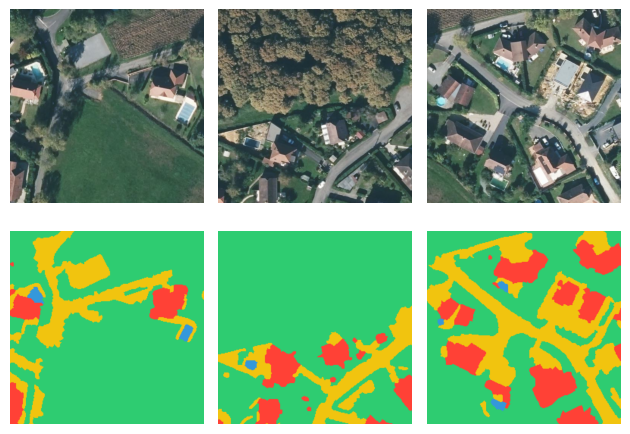

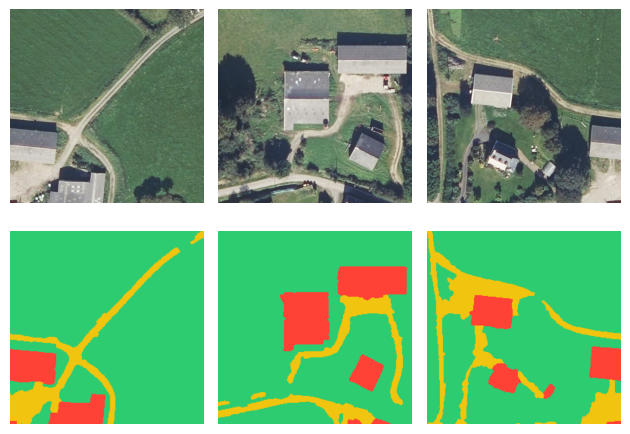

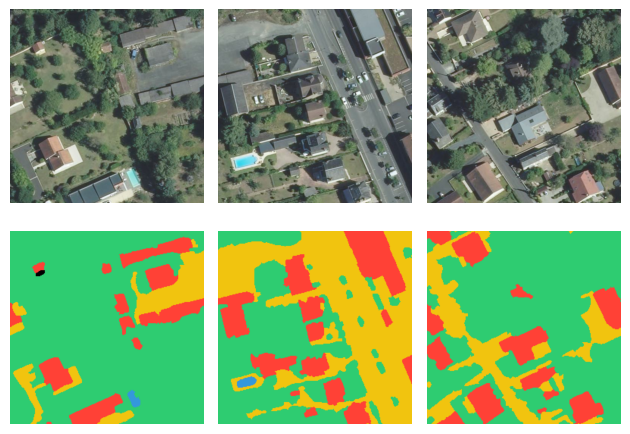

In [47]:
import matplotlib.pyplot as plt
import rasterio
import glob
import warnings
import torch 
import numpy as np 
import copy
import sklearn

# Choisir entre Cairanne_84, Chateauroux_36, Chissey_71, Claveyson_26, Fessenheim_68, 
# MaelPestivien_22, SaintCyr_69, SaintHilaire_61, SaintMartin_15, Sauvagnon_64

warnings.filterwarnings('ignore')

train_zone = 'Sauvagnon_64'
val_zone = 'MaelPestivien_22'
test_zone = 'Chateauroux_36'

def load_images(zone):
    images_paths = glob.glob(f"sample/{zone}/IMG_*.jpg")
    annotations_paths = [path.replace('IMG', 'MSK').replace('jpg', 'tif') for path in images_paths]
    imgs = torch.stack([torch.tensor(rasterio.open(image).read()).float() for image in images_paths])
    annots_19 = torch.stack([torch.tensor(rasterio.open(annot).read()[0]).int() for annot in annotations_paths]) - 1
    mapping_19_to_4_classes = torch.tensor([0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 1, 2, 4, 4, 4, 4, 4, 4])
    annots_5 = mapping_19_to_4_classes[annots_19]
    return imgs, annots_19, annots_5
    
images_paths = glob.glob(f"sample/{train_zone}/IMG_*.jpg")
annotations_paths = [path.replace('IMG', 'MSK').replace('jpg', 'tif') for path in images_paths]

rvb_mapping_19_classes = torch.tensor([[219, 14, 154], [147, 142, 123], [248, 12, 0], [169, 113, 1], [21, 83, 174], [25, 74, 38], [70, 228, 131],
                                   [243, 166, 13], [102, 0, 130], [85, 255, 0], [255, 243, 13], [228, 223, 124], [61, 230, 235], [255, 255, 255],
                                   [138, 179, 160], [107, 113, 79], [197, 220, 66], [153, 153, 255], [0, 0, 0]])
rvb_mapping_5_classes = torch.tensor([[255, 65, 54], [241, 196, 15], [52, 152, 219], [46, 204, 113], [0, 0, 0]])

def plot_images(imgs, annots, mapping, preds=None):
    n_rows = 2 if preds is None else 3
    for k, (image, annotation) in enumerate(zip(imgs, annots)):
        img = image.permute(1,2,0).int()
        annotation = mapping[annotation]
        plt.subplot(n_rows, 3, k + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(n_rows, 3, 3 + k + 1)
        plt.imshow(annotation)
        plt.axis('off')
        if preds is not None:
            pred = mapping[preds[k]]
            plt.subplot(n_rows, 3, 6 + k + 1)
            plt.imshow(pred)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

train_images, train_annotations_19, train_annotations = load_images(train_zone)
val_images, val_annotations_19, val_annotations = load_images(val_zone)
test_images, test_annotations_19, test_annotations = load_images(test_zone)

plot_images(train_images, train_annotations, rvb_mapping_5_classes)
plot_images(val_images, val_annotations, rvb_mapping_5_classes)
plot_images(test_images, test_annotations, rvb_mapping_5_classes)


In [28]:
model = torch.nn.Sequential(torch.nn.Conv2d(3, 4, 7, padding=3, dilation=1, groups=1, bias=True, padding_mode='reflect', device='cuda'),
                            torch.nn.ReLU()
                           )
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model) # 3 * 4 * 7 * 7 + 4

592

In [13]:
mean, std = torch.cat([train_images, val_images]).mean((0, 2, 3)), torch.cat([train_images, val_images]).std((0, 2, 3))

normed_train_images = (train_images - mean[..., None, None]) / std[..., None, None]
normed_val_images = (val_images - mean[..., None, None]) / std[..., None, None]
normed_test_images = (test_images - mean[..., None, None]) / std[..., None, None]

In [29]:
normed_train_images = normed_train_images.to('cuda')
train_annotations = train_annotations.to('cuda')

normed_val_images = normed_val_images.to('cuda')
val_annotations = val_annotations.to('cuda')

optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max")
criterion = torch.nn.CrossEntropyLoss(ignore_index=4)

train_accs, val_accs = [], []
train_losses, val_losses = [], []
best_val_loss = torch.inf
best_model = None
for i in range(1, 101):     
    model.train()
    optimizer.zero_grad()
    out = model(normed_train_images)
    pred = torch.argmax(out, dim=1)
    loss = criterion(out, train_annotations)
    acc = (pred == train_annotations).sum() / (512*512*3) * 100
    loss.backward()
    optimizer.step()
    scheduler.step(acc)
    train_losses.append(float(loss.item()))
    train_accs.append(float(acc.item()))
    if i % 5 == 0:
        model.eval()
        with torch.no_grad():
            out = model(normed_val_images)
            pred = torch.argmax(out, dim=1)
            val_loss = float(criterion(out, val_annotations).item())
            val_losses.append(val_loss)
            val_accs.append(float((pred == val_annotations).sum() / (512*512*3) * 100))
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(model)

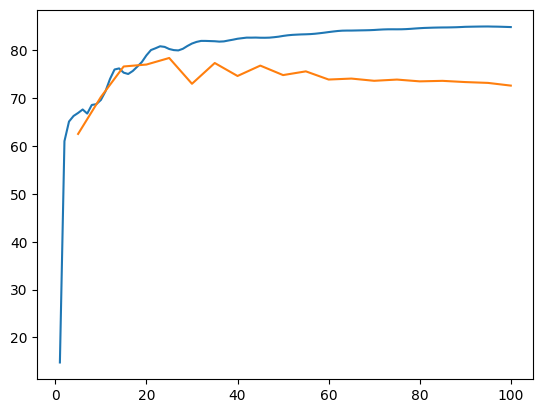

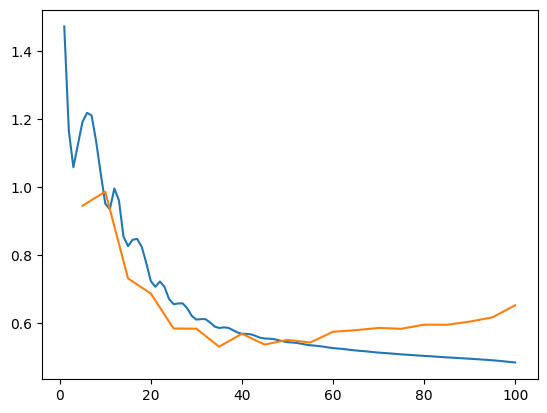

In [30]:
plt.plot(range(1, 101), train_accs)
plt.plot(range(5, 101, 5), val_accs)
plt.show()
plt.plot(range(1, 101), train_losses)
plt.plot(range(5, 101, 5), val_losses)
plt.show()

In [61]:
best_model.eval()
with torch.no_grad():
    out = model(normed_val_images.to('cuda'))
    pred = torch.argmax(out, dim=1)
conf_mat = sklearn.metrics.confusion_matrix(val_annotations.flatten().numpy(), pred.cpu().flatten().numpy(), labels=[0,1,2,3])

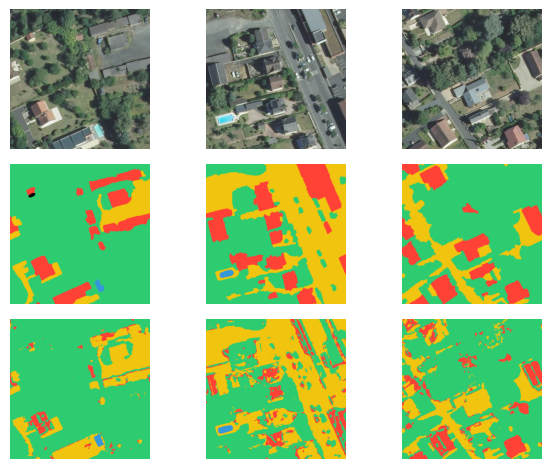

In [46]:
plot_images(test_images, test_annotations, rvb_mapping_5_classes, pred.cpu())

In [62]:
overall_acc = np.trace(conf_mat) / np.sum(conf_mat) * 100
per_class_acc = np.diag(conf_mat) / (conf_mat.sum(axis=1) + 1e-17) * 100
mean_acc = np.mean(per_class_acc) 

print(f"Overall Accuracy: {overall_acc:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Per-class Accuracy: {per_class_acc}")

Overall Accuracy: 72.6148
Mean Accuracy: 39.6781
Per-class Accuracy: [17.79276919 59.55654531  0.         81.36306187]
